In [1]:
#Importation needed 
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler 
from sklearn.dummy import DummyRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Masking , Bidirectional, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from src.helpers_death_regression import*

**1) Data loading**

In [2]:
SEGMENT_LENGTH = 900 
FEATURE_COLS = ['X', 'Y', 'Speed', 'turning_angle']  
FEATURE_COLS_MAPPING = {
    'X': 0, 
    'Y': 1, 
    'Speed': 2, 
    'turning_angle': 3 
}
DEBUG = False  # allow or not some debug print 
try:
    data_result = load_data_death_regressor(
        data_dir=os.getcwd(),
        segments_subdir="preprocessed_data/segments",
        lifespan_file="TERBINAFINE/lifespan_summary.csv",
        segment_length=SEGMENT_LENGTH,
        feature_cols=FEATURE_COLS,
        debug_mode=DEBUG
)
    # Access the loaded segments:
    all_segments = data_result['segments']
except SystemExit:
     print("Data loading terminated due to critical error.")

Loaded 104 lifespan entries. Example keys: ['20240924_piworm09_1', '20240924_piworm09_2', '20240924_piworm09_3', '20240924_piworm09_4', '20240924_piworm09_5']
------------------------------------------------------------
---- Segment Loading Summary ----
Segment files found: 8150
Segments accepted: 8150
Rejection counts: {'No_Lifespan_Match': 0, 'Missing_Features': 0, 'Missing_Worm_ID': 0, 'After_Death': 0, 'Pattern_Mismatch': 0, 'Read_Error': 0, 'Empty_Segment': 0}
------------------------------------------------------------


**2) Data Split Strategy: Worm-Level Separation**

To prevent data leakage, we perform a split at the individual level (worm_id). This ensures that the segments used for testing do not belong to a worm already seen during training.

In [3]:
# ============================================================
# WORM-LEVEL SPLIT
# Grouping segments by 'worm_id' ensures that all data from a single
# organism remains within the same set (train/val/test).
# ============================================================
worm_to_segments = defaultdict(list)
for seg in all_segments:
    worm_to_segments[seg['worm_id']].append(seg)

def get_segments_from_worms(worm_list_ids):
    """Retrieves the list of segments corresponding to the provided Worm IDs."""
    return [
        seg for w_id in worm_list_ids
        for seg in worm_to_segments[w_id]
    ]

all_worm_ids = list(worm_to_segments.keys())
# Splitting the organism IDs
train_worms_ids, temp_worms = train_test_split(
    all_worm_ids, test_size=0.3, random_state=42
)
val_worms_ids, test_worms_ids   = train_test_split(
    temp_worms, test_size=0.5, random_state=42
)

print("\n--- Worm ID Distribution ---")
print(f"Number of worms used for training: {len(train_worms_ids)}")
print(f"Number of worms used for validation: {len(val_worms_ids)}")
print(f"Number of worms used for testing: {len(test_worms_ids)}")

# Creating the final segment datasets
train_segments = get_segments_from_worms(train_worms_ids)
val_segments   = get_segments_from_worms(val_worms_ids)
test_segments  = get_segments_from_worms(test_worms_ids)
# Displaying the segment count
print("\n--- Total Segment Distribution ---")
print(f"Train segments: {len(train_segments)}")
print(f"Val segments  : {len(val_segments)}")
print(f"Test segments : {len(test_segments)}")


--- Worm ID Distribution ---
Number of worms used for training: 72
Number of worms used for validation: 16
Number of worms used for testing: 16

--- Total Segment Distribution ---
Train segments: 5670
Val segments  : 1362
Test segments : 1118


In [4]:
FEATURES_TO_USE = ['Speed', 'turning_angle']
X_train, y_train, mask_train = prepare_X_y(
    segments=train_segments, 
    feature_names=FEATURES_TO_USE, 
    feature_mapping=FEATURE_COLS_MAPPING
)
X_val, y_val, mask_val = prepare_X_y(
    segments=val_segments, 
    feature_names=FEATURES_TO_USE, 
    feature_mapping=FEATURE_COLS_MAPPING
)
X_test, y_test, mask_test = prepare_X_y(
    segments=test_segments,
    feature_names=FEATURES_TO_USE, 
    feature_mapping=FEATURE_COLS_MAPPING
)

print(f"Features used: {FEATURES_TO_USE}")
print("Train shapes (X, y, mask):", X_train.shape, y_train.shape, mask_train.shape)
print("Validation shapes (X, y, mask):", X_val.shape, y_val.shape, mask_val.shape)
print("Test shapes (X, y, mask):", X_test.shape, y_test.shape, mask_test.shape)


Features used: ['Speed', 'turning_angle']
Train shapes (X, y, mask): (5670, 900, 2) (5670,) (5670, 900)
Validation shapes (X, y, mask): (1362, 900, 2) (1362,) (1362, 900)
Test shapes (X, y, mask): (1118, 900, 2) (1118,) (1118, 900)


**3) feature visualisation**

--- 1. Feature Distribution Histograms ---


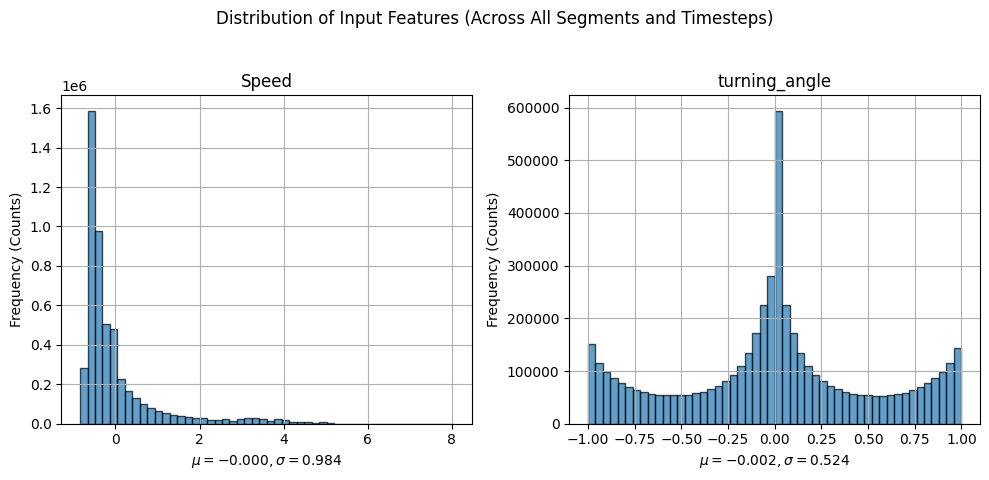


--- 2. Feature Statistics (X_train) ---
Features: ['Speed', 'turning_angle']
Mean per Feature (Across all time/segments): [-0.0002 -0.0024]
Standard Deviation (Std):                    [0.9818 0.5228]

--- 3. Target Variable Statistics and Histogram (y_train) ---


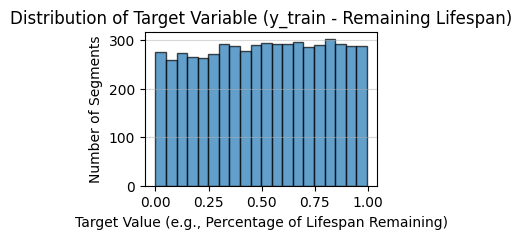

Mean of y_train:       0.5059
Standard Deviation (Std): 0.2854
Minimum value of y_train: 0.0000
Maximum value of y_train: 0.9950


In [5]:
plot_feature_and_target_distributions(
    X_train=X_train,
    y_train=y_train,
    feature_names_list=FEATURES_TO_USE
)

**4) Model of reference baseline**

In [6]:
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train, y_train) #calculate the mean)
y_pred_dummy_reg = dummy_reg.predict(X_test)

mae_base = mean_absolute_error(y_test, y_pred_dummy_reg)
r2_base = r2_score(y_test, y_pred_dummy_reg)

print(f"\n[REGRESSION] Baseline Mean :")
print(f"  - MAE : {mae_base:.4f}")
print(f"  - R2 : {r2_base:.4f}")


[REGRESSION] Baseline Mean :
  - MAE : 0.2439
  - R2 : -0.0000


### We keep 3 way of use the Bidirectionnal LSTM Model ###

**The first one is to keep only one sample every N sample we see that it seem easier for the model to extract the features** 

In [10]:
N = 4

# 1. Sous-échantillonnage de X (la séquence temporelle) et de mask (le masque temporel)
X_train_subsampled = X_train[:, ::N, :] 
mask_train_subsampled = mask_train[:, ::N]

# 2. y_train ne bouge pas car il n'a qu'une seule valeur par segment (5670,)
y_train_subsampled = y_train

# Répéter pour les autres ensembles
X_val_subsampled = X_val[:, ::N, :] 
mask_val_subsampled = mask_val[:, ::N]
y_val_subsampled = y_val # Pas de sous-échantillonnage

X_test_subsampled = X_test[:, ::N, :]
mask_test_subsampled = mask_test[:, ::N]
y_test_subsampled = y_test # Pas de sous-échantillonnage

In [11]:
# ---  Hyperparameters ---
LSTM_UNITS = 256
REGULARIZER = regularizers.l2(0.0001)
INITIAL_LEARNING_RATE = 0.0001 
BATCH_SIZE = 128
mask_value = 0.0 


# --- EVOLVED 3-LAYER BI-LSTM MODEL ---
model_evolved = Sequential([
    # 1. Masking Layer
    # Skips time steps where all feature values are 'mask_value' (0.0), 
    Masking(mask_value=mask_value, input_shape=(X_train_subsampled.shape[1], X_train_subsampled.shape[2])),
    
    # 2. First Bi-LSTM Layer
    tf.keras.layers.Bidirectional(
        LSTM(LSTM_UNITS, return_sequences=True, kernel_regularizer=REGULARIZER)
    ),
    
    Dropout(0.3),
    
    # 3. Second Bi-LSTM Layer
    tf.keras.layers.Bidirectional(
        LSTM(LSTM_UNITS, return_sequences=True, kernel_regularizer=REGULARIZER)
    ),
    
    Dropout(0.3), 

    # 4. Third Bi-LSTM Layer (Final Recurrent Layer)
    # 'return_sequences=False' extracts only the output state of the last valid time step, 
    # collapsing the time dimension before the Dense layers.
    tf.keras.layers.Bidirectional(
        LSTM(LSTM_UNITS // 2, return_sequences=False, kernel_regularizer=REGULARIZER)
    ),
    
    Dropout(0.2),

    # 8. Dense Layers (Feature Processing)
    Dense(256, activation='relu', kernel_regularizer=REGULARIZER),
    Dense(128, activation='relu', kernel_regularizer=REGULARIZER),
    
    # 9. Regression Output
    # Single linear output unit for predicting the continuous target (time-to-death).
    Dense(1,activation='sigmoid') 
])
    
# --- Compilation ---
# Using Adam optimizer and Huber loss, which is less sensitive to outliers than MSE.
model_evolved.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE), 
    loss=tf.keras.losses.Huber(delta=2.0), 
    metrics=['mae']
)

# Callbacks for early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

print(f"Starting training for the 3-layer Bi-LSTM model with T={X_train_subsampled.shape[1]} timesteps...")

# --- Training ---
history_evolved = model_evolved.fit(
    X_train_subsampled, y_train_subsampled,           
    validation_data=(X_val_subsampled, y_val_subsampled),
    epochs=40,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
)
print("Training of the 3-layer Bi-LSTM model completed.")

/Users/remymuhlethaler/anaconda3/envs/celegans/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Starting training for the 3-layer Bi-LSTM model with T=225 timesteps...
Epoch 1/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - loss: 0.2919 - mae: 0.1909 - val_loss: 0.2666 - val_mae: 0.1750
Epoch 2/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 179s 4s/step - loss: 0.2485 - mae: 0.1688 - val_loss: 0.2302 - val_mae: 0.1698
Epoch 3/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 218s 5s/step - loss: 0.2151 - mae: 0.1681 - val_loss: 0.1988 - val_mae: 0.1706
Epoch 4/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 176s 4s/step - loss: 0.1865 - mae: 0.1677 - val_loss: 0.1726 - val_mae: 0.1690
Epoch 5/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 199s 4s/step - loss: 0.1621 - mae: 0.1661 - val_loss: 0.1500 - val_mae: 0.1669
Epoch 6/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 220s 5s/step - loss: 0.1416 - mae: 0.1662 - val_loss: 0.1318 - val_mae: 0.1716
Epoch 7/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 193s 4s/step - loss: 0.1242 - mae: 0.1664 - val_loss: 0.1153 - val_mae: 0.1656
Epoch 8/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 216s 5s/step - loss: 0.1096 - mae: 0.1664 - val_loss: 0.1026 - val_mae:

35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 446ms/step
--- RESULTS ---
R2 Score : 0.4239
MAE      : 0.1664


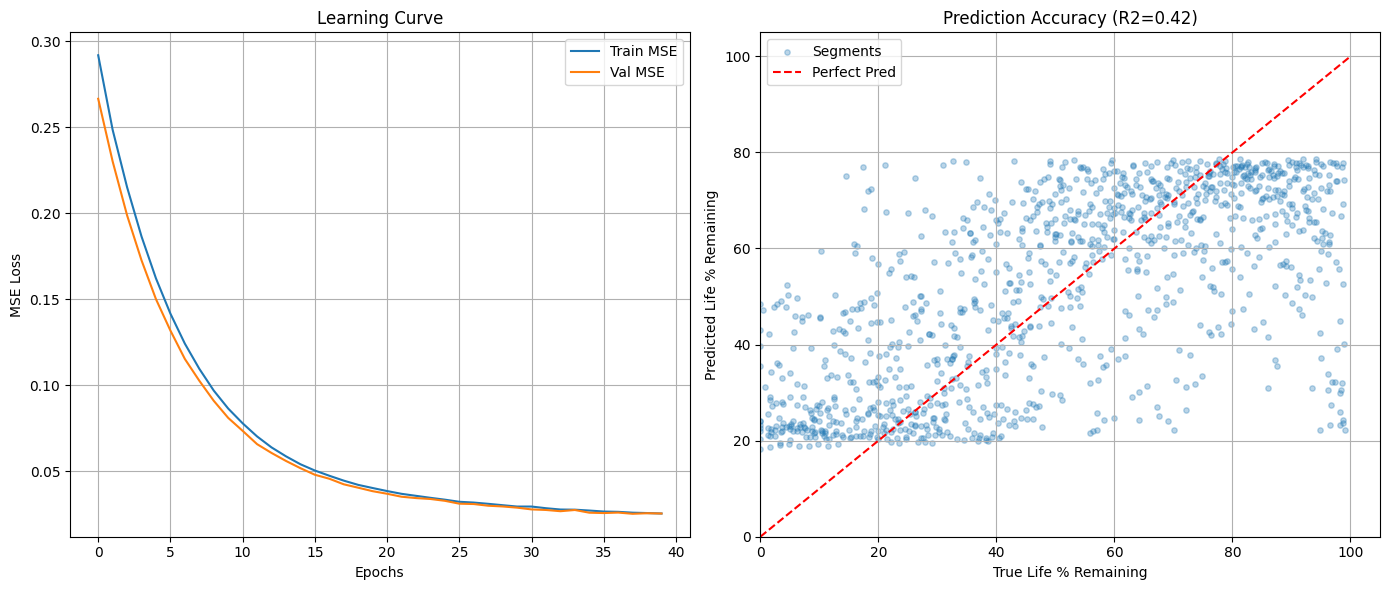

In [12]:
evaluate_and_plot_results(model_evolved, X_test_subsampled, y_test_subsampled, history_evolved)

**The second is to keep is only a window of 650 in the the 900 segement length**


In [13]:

slice_size = 650

X_train_slice = X_train[:, -slice_size:, :]
X_val_slice = X_val[:, -slice_size:, :]
X_test_slice = X_test[:, -slice_size:, :]

y_train_slice = y_train
y_val_slice = y_val
y_test_slice = y_test

mask_train_slice = mask_train[:, -slice_size:]
mask_val_slice = mask_val[:, -slice_size:]
mask_test_slice = mask_test[:, -slice_size:]
print("Train slice shapes (X, y, mask):", X_train_slice.shape, y_train_slice.shape, mask_train_slice.shape)
print("Validation slice shapes (X, y, mask):", X_val_slice.shape, y_val_slice.shape, mask_val_slice.shape)
print("Test slice shapes (X, y, mask):", X_test_slice.shape, y_test_slice.shape, mask_test_slice.shape)

Train slice shapes (X, y, mask): (5670, 650, 2) (5670,) (5670, 650)
Validation slice shapes (X, y, mask): (1362, 650, 2) (1362,) (1362, 650)
Test slice shapes (X, y, mask): (1118, 650, 2) (1118,) (1118, 650)


In [14]:
LSTM_UNITS = 256
REGULARIZER = regularizers.l2(0.0001)
INITIAL_LEARNING_RATE = 0.0001 
BATCH_SIZE = 64
mask_value = 0.0 

NEW_SEQUENCE_LENGTH = X_train_slice.shape[1] 


model_slice = Sequential([
    # 1. Couche de Masquage
    Masking(
        mask_value=mask_value, 
        input_shape=(NEW_SEQUENCE_LENGTH, X_train_slice.shape[2])
    ),
    
    # 2. First layer Bi-LSTM
    tf.keras.layers.Bidirectional(
        LSTM(LSTM_UNITS, return_sequences=True, kernel_regularizer=REGULARIZER)
    ),
    
    # 3. Dropout
    Dropout(0.2),
    
    # 4. Second Layer Bi-LSTM
    tf.keras.layers.Bidirectional(
        LSTM(LSTM_UNITS, return_sequences=True, kernel_regularizer=REGULARIZER)
    ),
    
    # 5. Dropout
    Dropout(0.2),

    # 6. Third Layer Bi-LSTM 
    tf.keras.layers.Bidirectional(
        LSTM(LSTM_UNITS // 2, return_sequences=False, kernel_regularizer=REGULARIZER)
    ),
    
    # 7. Dropout
    Dropout(0.1),

    # 8. Couches Denses
    Dense(64, activation='relu', kernel_regularizer=REGULARIZER),
    Dense(32, activation='relu', kernel_regularizer=REGULARIZER),
    
    Dense(1) 
])
    
# --- Compilation ---
model_slice.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE), 
    loss=tf.keras.losses.Huber(delta=2.0), 
    metrics=['mae']
)

# Callbacks d'arrêt précoce 
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

history_slice = model_slice.fit( 
    X_train_slice, y_train_slice,           
    validation_data=(X_val_slice, y_val_slice), 
    epochs=100,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop]
)


/Users/remymuhlethaler/anaconda3/envs/celegans/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 458s 5s/step - loss: 0.2808 - mae: 0.2510 - val_loss: 0.2298 - val_mae: 0.1829
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 511s 6s/step - loss: 0.2095 - mae: 0.1816 - val_loss: 0.1908 - val_mae: 0.1866
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 498s 6s/step - loss: 0.1734 - mae: 0.1777 - val_loss: 0.1578 - val_mae: 0.1790
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 505s 6s/step - loss: 0.1454 - mae: 0.1757 - val_loss: 0.1339 - val_mae: 0.1736
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 538s 6s/step - loss: 0.1250 - mae: 0.1757 - val_loss: 0.1160 - val_mae: 0.1747
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 554s 6s/step - loss: 0.1089 - mae: 0.1745 - val_loss: 0.1025 - val_mae: 0.1787
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 541s 6s/step - loss: 0.0969 - mae: 0.1741 - val_loss: 0.0922 - val_mae: 0.1708
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 532s 6s/step - loss: 0.0877 - mae: 0.1734 - val_loss: 0.0840 - val_mae: 0.1760
Epoch 9/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 547s 6s/step - lo

35/35 ━━━━━━━━━━━━━━━━━━━━ 33s 921ms/step
--- RESULTS ---
R2 Score : 0.4043
MAE      : 0.1713


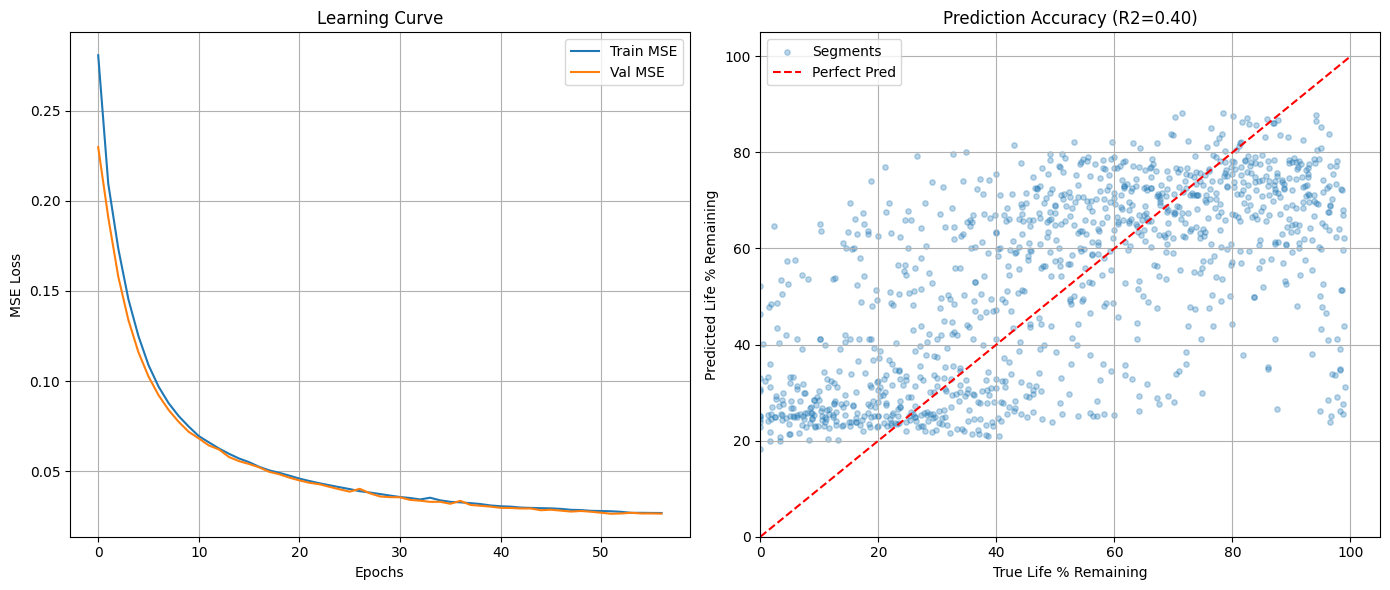

In [15]:
evaluate_and_plot_results(model_slice, X_test_slice, y_test_slice, history_slice)

**The third is to keep the 900 segement length**


In [17]:
LSTM_UNITS = 256
REGULARIZER = regularizers.l2(0.0001)
INITIAL_LEARNING_RATE = 0.0001 
BATCH_SIZE = 64
mask_value = 0.0 



model = Sequential([
    # 1. Couche de Masquage
    Masking(
        mask_value=mask_value, 
        input_shape=(X_train.shape[1] , X_train.shape[2])
    ),
    
    # 2. First layer Bi-LSTM
    tf.keras.layers.Bidirectional(
        LSTM(LSTM_UNITS, return_sequences=True, kernel_regularizer=REGULARIZER)
    ),
    
    # 3. Dropout
    Dropout(0.2),
    
    # 4. Second Layer Bi-LSTM
    tf.keras.layers.Bidirectional(
        LSTM(LSTM_UNITS, return_sequences=True, kernel_regularizer=REGULARIZER)
    ),
    
    # 5. Dropout
    Dropout(0.2),

    # 6. Third Layer Bi-LSTM 
    tf.keras.layers.Bidirectional(
        LSTM(LSTM_UNITS // 2, return_sequences=False, kernel_regularizer=REGULARIZER)
    ),
    
    # 7. Dropout
    Dropout(0.1),

    # 8. Couches Denses
    Dense(64, activation='relu', kernel_regularizer=REGULARIZER),
    Dense(32, activation='relu', kernel_regularizer=REGULARIZER),
    
    Dense(1, activation='sigmoid')
])
    
# --- Compilation ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE), 
    loss=tf.keras.losses.Huber(delta=2.0), 
    metrics=['mae']
)

# Callbacks d'arrêt précoce 
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

history = model.fit( 
    X_train, y_train,           
    validation_data=(X_val, y_val), 
    epochs=100,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop]
)

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 623s 7s/step - loss: 0.2465 - mae: 0.1870 - val_loss: 0.2091 - val_mae: 0.1736
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 657s 7s/step - loss: 0.1828 - mae: 0.1725 - val_loss: 0.1577 - val_mae: 0.1755
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 694s 8s/step - loss: 0.1386 - mae: 0.1706 - val_loss: 0.1208 - val_mae: 0.1703
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 734s 8s/step - loss: 0.1074 - mae: 0.1709 - val_loss: 0.0957 - val_mae: 0.1714
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 732s 8s/step - loss: 0.0857 - mae: 0.1718 - val_loss: 0.0756 - val_mae: 0.1696
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1912s 22s/step - loss: 0.0696 - mae: 0.1706 - val_loss: 0.0637 - val_mae: 0.1733
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 658s 7s/step - loss: 0.0588 - mae: 0.1709 - val_loss: 0.0537 - val_mae: 0.1721
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 675s 8s/step - loss: 0.0509 - mae: 0.1700 - val_loss: 0.0469 - val_mae: 0.1692
Epoch 9/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 660s 7s/step - 

35/35 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step
--- RESULTS ---
R2 Score : 0.3442
MAE      : 0.1811


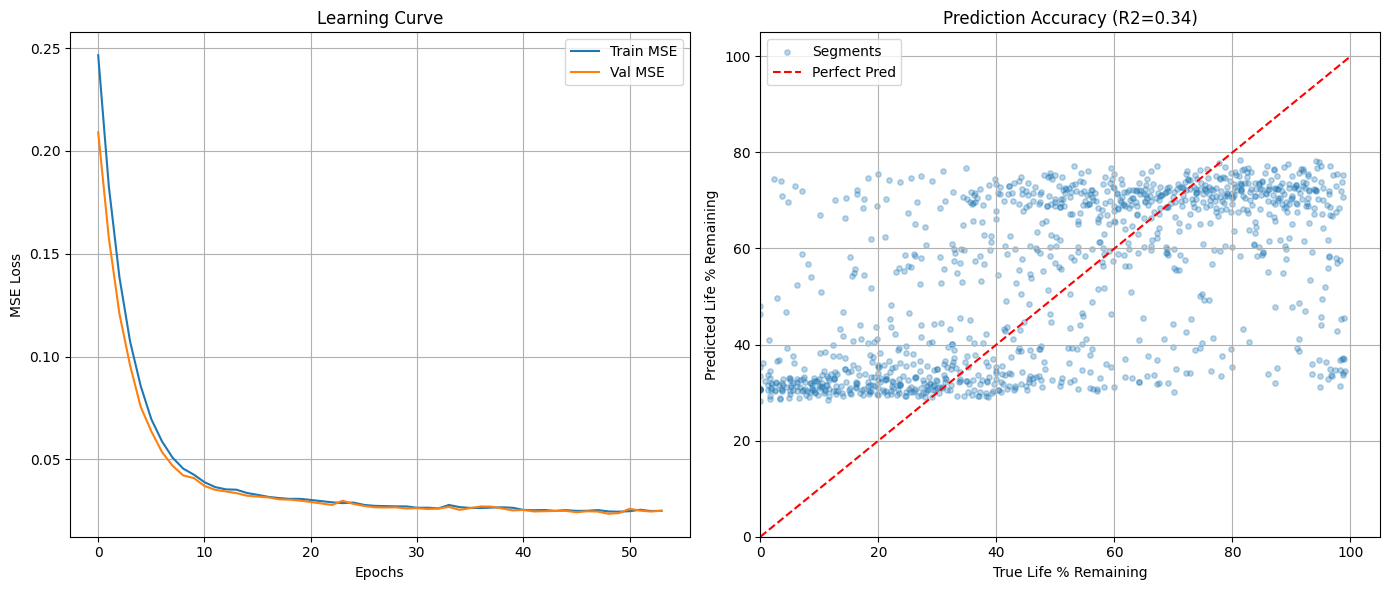

In [18]:
evaluate_and_plot_results(model, X_test, y_test, history)